# PyKAN

In [109]:
import kan
import matplotlib.pyplot as plt
import numpy as np
import torch
from kan import KAN, create_dataset
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split

$$
f(\bf x) = \exp(\sin(\pi x_1)+ x_2^2)
$$

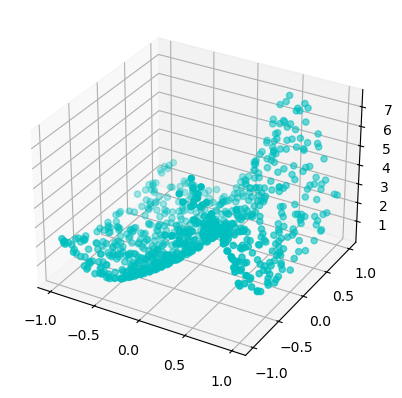

In [149]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)

# Create dataset
torch.manual_seed(0)

X = torch.rand(1000, 2) * 2 - 1 # Random points in [-1, 1]^2
y = f(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

# Plot dataset
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset['train_input'][:, 0], dataset['train_input'][:, 1], dataset['train_label'], c='c', marker='o')
plt.show()

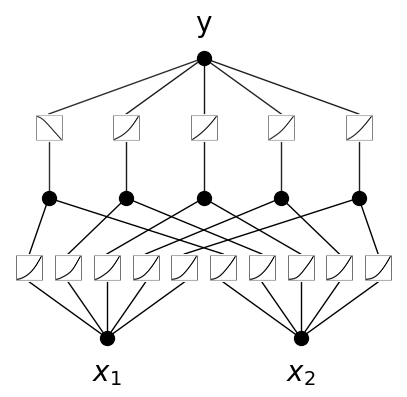

In [150]:
# Create KAN
model = KAN(width=[2,5,1], grid=3, k=3, seed=0)

# Plot
model(dataset['train_input'])
model.plot(beta=100, in_vars=['$x_1$', '$x_2$'], out_vars=['y']) # beta controls the transparency of the plot

In [151]:
# Train KAN
res = model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 1.12e-01 | test loss: 1.02e-01 | reg: 2.12e+01 : 100%|██| 20/20 [00:02<00:00,  7.67it/s]


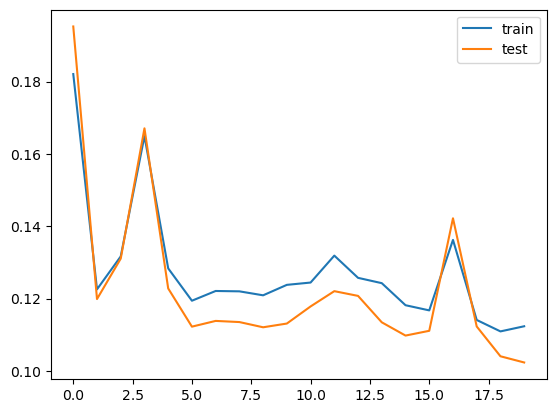

In [152]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(res["train_loss"], label="train")
ax.plot(res["test_loss"], label="test")
ax.legend()
plt.show()

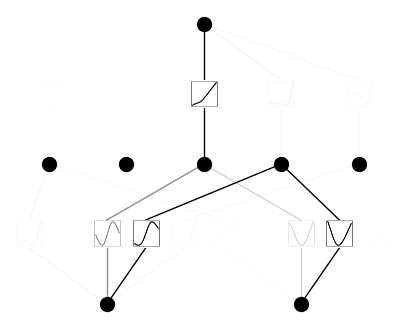

In [153]:
# After training
model.plot()

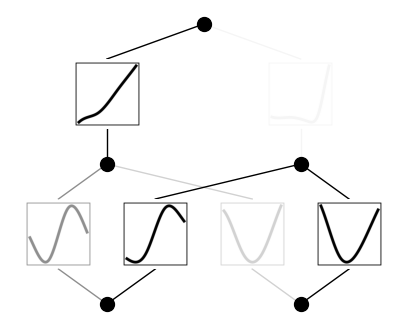

In [154]:
# Prune
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

In [159]:
model2.suggest_symbolic(0,0,0)

function , r2
sin , 0.9967146515846252
gaussian , 0.9280341863632202
tanh , 0.8861169815063477
sigmoid , 0.8810763359069824
arctan , 0.8664839863777161


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9967146515846252)

In [160]:
model2.fix_symbolic(0,0,0, "sin")

r2 is 0.9967146515846252


tensor(0.9967)

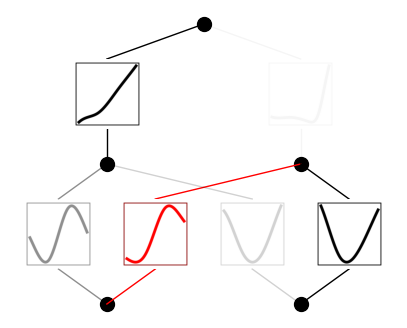

In [157]:
model2.plot()

# Classification

In [117]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder() 

# Iris dataset
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = enc.fit_transform(iris.target.reshape(-1, 1)).toarray()
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dataset = dict(train_input=X_train, train_label=y_train, test_input=X_test, test_label=y_test)

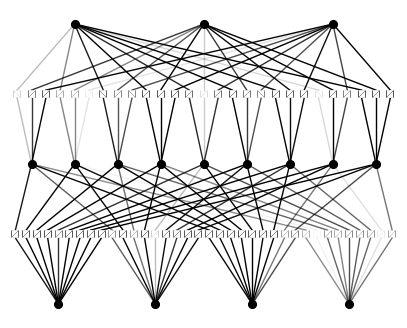

In [118]:
# Create KAN
model = KAN(width=[4,9,3], grid=3, k=3, seed=0)
model(X_train)
model.plot()

train loss: 5.32e-01 | test loss: 5.74e-01 | reg: 6.11e+01 : 100%|██| 20/20 [00:04<00:00,  4.02it/s]


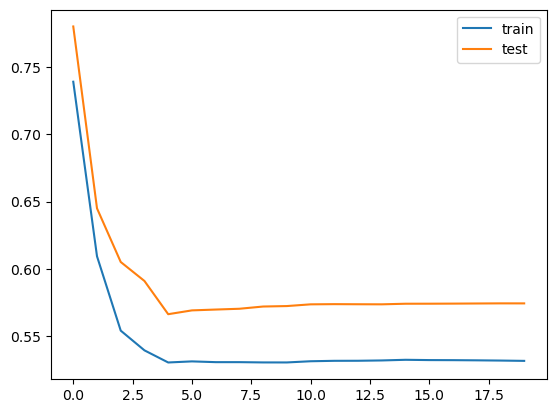

In [129]:
# Train KAN
from sklearn.metrics import accuracy_score

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == torch.argmax(dataset['train_label'], dim=1)).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == torch.argmax(dataset['test_label'], dim=1)).float())

res = model.train(dataset, opt="LBFGS", metrics=[train_acc, test_acc], steps=20, lamb=0.01, lamb_entropy=10., loss_fn=torch.nn.CrossEntropyLoss())

# Plot loss
fig, ax = plt.subplots()
ax.plot(res["train_loss"], label="train")
ax.plot(res["test_loss"], label="test")
ax.legend()
plt.show()

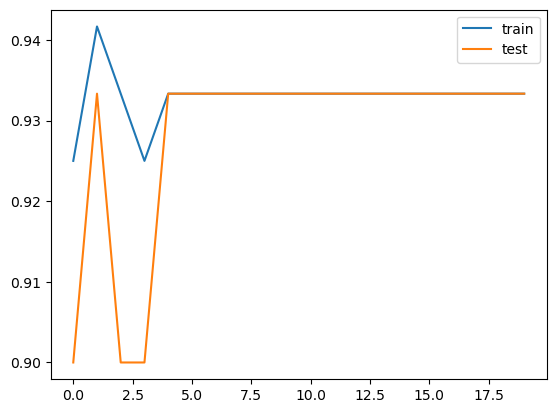

In [131]:
# Accuracy plot
fig, ax = plt.subplots()
ax.plot(res["train_acc"], label="train")
ax.plot(res["test_acc"], label="test")
ax.legend()
plt.show()

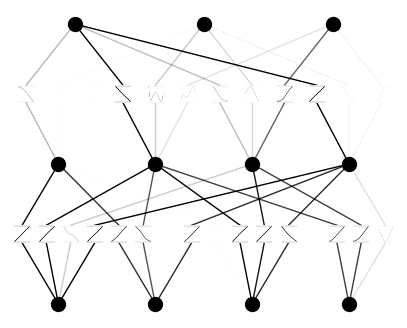

In [133]:
# Prune

model2 = model.prune()
model2(dataset['train_input'])
model2.plot(beta=5) # [4,4,3]-KAN

In [141]:
# Accuracy

(model2(dataset['test_input']).argmax(dim=1) == dataset['test_label'].argmax(dim=1)).float().mean() # 93.3%

tensor(0.9333)